# Train Model on Multiple Reservoirs Simultaneously

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor
import os

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.models.hyperparameter_tuning import *

In [2]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


## Data Processing
Process data for each reservoir as usual (conduct train/test/split, fill NaN with training mean, break into chunks, padding remainder) for each reservoir. Then, concat the tensors from each reservoir to form one train, val, and test tensor.

** Note that under this strategy, each reservoir is standardized according to its own training statistics, and not from the entire dataset

Shasta : 1944-01-01 to 2022-12-31 \
Folsom : 1963-01-01 to 2022-12-31 \
New Melones : 1980-01-01 to 2022-12-31 \
Berryessa : 1976-01-01 to 2022-12-31 \
Trinity : 1963-01-01 to 2022-12-31

In [3]:
def data_processing(name, transform_type, train_frac=0.6, val_frac=0.2, test_frac=0.2, left='1944-01-01', right='2022-12-31', log_names=[], return_scaler=False):
    """
    Run data processing pipeline. Return Dataloader objects for training and validation data
    Params:
    name -- str, name of reservoir to read
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window
    log_names -- list of column names (str) to take log of before running rest of pipeline. E.g. ['inflow', 'outflow', 'storage']
    return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
    """

    # Read in data, columns are [inflow, outflow, storage]
    df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window
    df = df[left:right].copy()

    # Take log of df columns that are in log_names
    for column_name in df.columns:
        if column_name in log_names:
            df[column_name] = np.log(df[column_name])
        else:
            continue

    # Run data processing pipeline
    pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=test_frac, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
    # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
    ts_train, ts_val, ts_test = pipeline.process_data(df) 

    # Separate inputs(X) and targets (y)
    # select inflow and doy as input features
    X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
    # select outflow as target feature
    y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

    if return_scaler:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), pipeline.scaler
    else:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [16]:
type(True * False)

int

In [4]:
def combine_reservoir_data(left_years_dict):
    """ 
    Run data processing for each requested reservoir, concatenate each respective train, val, test 
    tensors into one.
    Params:
    left_years_dict: dict, dictionary of year of first available data from each requested reservoir
    """
    # Collect train, val, test tensors from each reservoir and their respective src.data.data_processing.time_scaler() objects
    X_train_list = []
    y_train_list = []
    X_val_list = []
    y_val_list = []
    X_test_list = []
    y_test_list = []
    scaler_dict = {}

    # Run data processing for each reservoir
    for reservoir, left_year in left_years_dict.items():
        result = data_processing(name=reservoir, transform_type='standardize', train_frac=0.6, val_frac=0.2, test_frac=0.2,
                                 left=f'{left_year}-01-01', right='2022-12-31',
                                 return_scaler=True)
        # Save results
        X_train_list.append(result[0][0]) # (# chunks, chunk size, # features (e.g. inflow and doy))
        y_train_list.append(result[0][1]) # (# chunks, chunk size, 1 (outflow))
        X_val_list.append(result[1][0])
        y_val_list.append(result[1][1])
        X_test_list.append(result[2][0])
        y_test_list.append(result[2][1])
        scaler_dict[reservoir] = result[3]
        
    # Concat tensors along chunks dimension (dim = 0)
    X_train, y_train = torch.cat(X_train_list, dim=0), torch.cat(y_train_list, dim=0)
    X_val, y_val = torch.cat(X_val_list, dim=0), torch.cat(y_val_list, dim=0)
    X_test, y_test = torch.cat(X_test_list, dim=0), torch.cat(y_test_list, dim=0)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [5]:
# Store first available years for each reservoir
left_years_dict = {'Shasta':1944, 'Folsom':1963, 'New_Melones':1980, 'Berryessa':1976, 'Trinity':1963}

In [6]:
# Combine data from reservoirs
data_result = combine_reservoir_data(left_years_dict=left_years_dict)

In [7]:
# Shape of X_train and y_train
data_result[0][0].shape, data_result[0][1].shape

(torch.Size([61, 1095, 2]), torch.Size([61, 1095, 1]))

In [8]:
# Create PyTorch Dataset and Dataloader from training and validation
dataset_train, dataset_val = (TensorDataset(*data_result[0]), TensorDataset(*data_result[1]))
dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                    DataLoader(dataset_val, batch_size=1, shuffle=False))

## Train Model
Manually tune hyperparameters

In [9]:
# Instantiate model (Model 1a archeticture)
input_size = 2
hidden_size1 = 30
hidden_size2 = 15
output_size = 1
dropout_prob = 0.3
num_layers = 1
torch.manual_seed(0)
model = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                            hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Run training loop
train_losses, val_losses = training_loop(model=model, criterion=criterion, optimizer=optimizer, 
                                        patience=10, dataloader_train=dataloader_train, 
                                        dataloader_val=dataloader_val, epochs=1000)

Training epochs:   4%|▍         | 44/1000 [00:39<14:16,  1.12it/s]


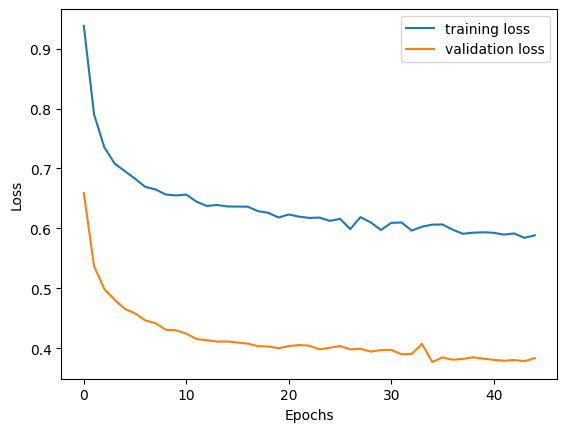

In [11]:
plt.figure()
plot_train_val(train_losses=train_losses, val_losses=val_losses)
plt.show()

In [12]:
# Evaluate performance
# Get predictions
y_hat_train, y_hat_val, y_hat_test = predict(model, data_result[0][0]), predict(model, data_result[1][0]), predict(model, data_result[2][0])
# Flatten and remove padding values
y_hat_train, y_train = flatten_rm_pad(y_hat=y_hat_train, y=data_result[0][1])
y_hat_val, y_val = flatten_rm_pad(y_hat=y_hat_val, y=data_result[1][1])
y_hat_test, y_test = flatten_rm_pad(y_hat=y_hat_test, y=data_result[2][1])
# Find and save R2 metrics
r2_train = r2_score(y_pred=y_hat_train, y_true=y_train)
r2_val = r2_score(y_pred=y_hat_val, y_true=y_val)
r2_test = r2_score(y_pred=y_hat_test, y_true=y_test)

print(f"Training R2: {r2_train}, Validation R2: {r2_val}, Testing R2: {r2_test}")

Training R2: 0.4526737440885529, Validation R2: 0.4839262111383311, Testing R2: 0.3553077206653823


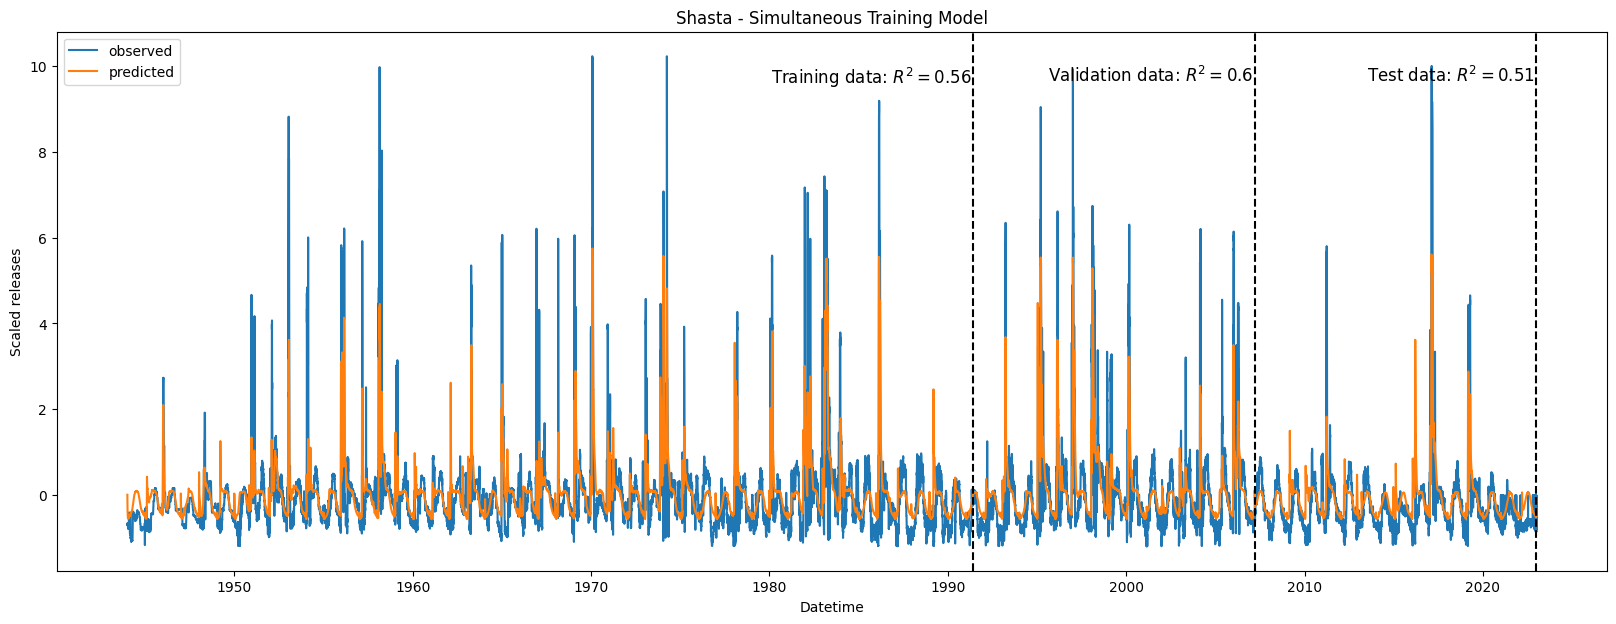

In [22]:
# Try model on Shasta reservoir
shasta_data = data_processing(name='Shasta', transform_type='standardize')
X_train_shasta, X_val_shasta, X_test_shasta = shasta_data[0][0], shasta_data[1][0], shasta_data[2][0]
y_train_shasta, y_val_shasta, y_test_shasta = shasta_data[0][1], shasta_data[1][1], shasta_data[2][1]
fig, ax = plt.subplots(figsize=(20, 7))
plot_and_eval(model, X_train=X_train_shasta, X_val=X_val_shasta, X_test=X_test_shasta,
              y_train=y_train_shasta, y_val=y_val_shasta, y_test=y_test_shasta,
              datetime_index=pd.date_range(start='1944-01-01', end='2022-12-31', freq='D'),
              ax=ax, text_ypos=10)
ax.set_title('Shasta - Simultaneous Training Model')
plt.show()

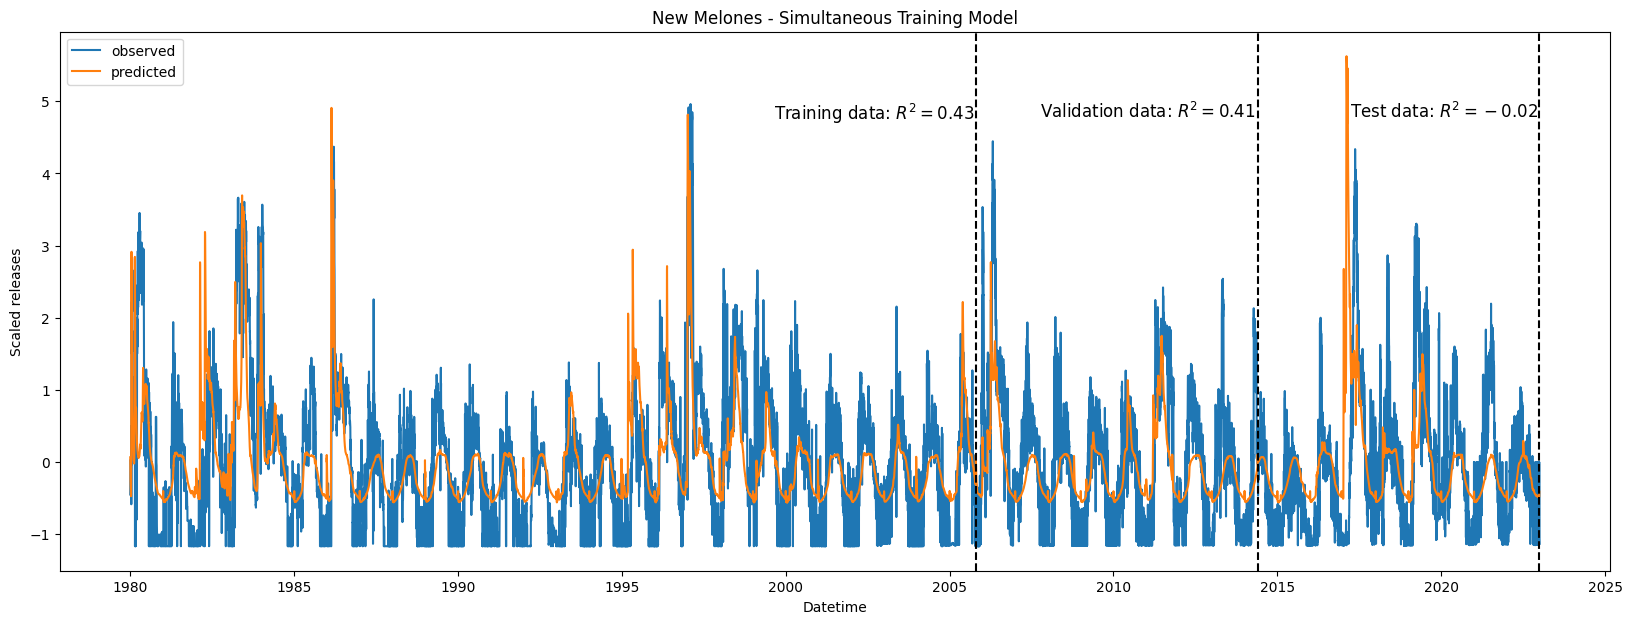

In [32]:
# Try model on New Melones reservoir
melones_data = data_processing(name='New_Melones', transform_type='standardize', left='1980-01-01')
X_train_melones, X_val_melones, X_test_melones = melones_data[0][0], melones_data[1][0], melones_data[2][0]
y_train_melones, y_val_melones, y_test_melones = melones_data[0][1], melones_data[1][1], melones_data[2][1]
fig, ax = plt.subplots(figsize=(20, 7))
plot_and_eval(model, X_train=X_train_melones, X_val=X_val_melones, X_test=X_test_melones,
              y_train=y_train_melones, y_val=y_val_melones, y_test=y_test_melones,
              datetime_index=pd.date_range(start='1980-01-01', end='2022-12-31', freq='D'),
              ax=ax, text_ypos=5)
ax.set_title('New Melones - Simultaneous Training Model')
plt.show()

Overall, performance is worse than when models are fitted to the reservoirs individually. Is this due to the observed difference in reservoir operating behavior?

## Can we finetune the simultaneous model to a particular reservoir?

### Try for Shasta Reservoir

In [36]:
class LSTMModel1_finetune(nn.Module):
    """Same architecture as Model 1, but only returns sequence of hidden states and LAST hidden/cell state.
    Uses efficient PyTorch LSTM() layer"""
    def __init__(self, simul_model):
        super(LSTMModel1_finetune, self).__init__()
        self.simul_model = simul_model # larger model trained on all reservoirs

    def forward(self, x):
        # x is (batch size, timesteps, input size)
        self.simul_model.eval()
        out, (h_n, c_n) = self.simul_model(x) # out is (batch size, timesteps, hidden size 1)
        return out, (h_n, c_n)

In [38]:
# Create PyTorch Dataset and Dataloader from training and validation
dataset_train_shasta, dataset_val_shasta = (TensorDataset(X_train_shasta, y_train_shasta), TensorDataset(X_val_shasta, y_val_shasta))
dataloader_train_shasta, dataloader_val_shasta = (DataLoader(dataset_train_shasta, batch_size=1, shuffle=False), 
                                    DataLoader(dataset_val_shasta, batch_size=1, shuffle=False))

In [39]:
# Instantiate Shasta finetuning model
torch.manual_seed(0)
shasta_finetune_model = LSTMModel1_finetune(simul_model=model)
criterion = nn.MSELoss()
optimizer = optim.Adam(shasta_finetune_model.parameters(), lr=0.001)

In [40]:
# Run training loop (finetune model to shasta)
train_losses_shasta, val_losses_shasta = training_loop(model=shasta_finetune_model, criterion=criterion, optimizer=optimizer, 
                                        patience=10, dataloader_train=dataloader_train_shasta, 
                                        dataloader_val=dataloader_val_shasta, epochs=1000)

Training epochs:   2%|▏         | 22/1000 [00:03<02:55,  5.59it/s]


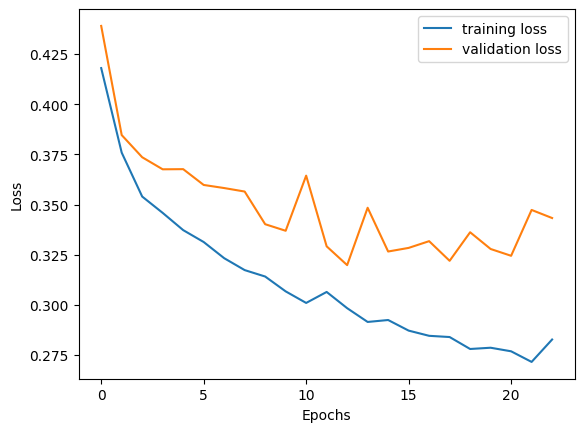

In [41]:
plt.figure()
plot_train_val(train_losses=train_losses_shasta, val_losses=val_losses_shasta)
plt.show()

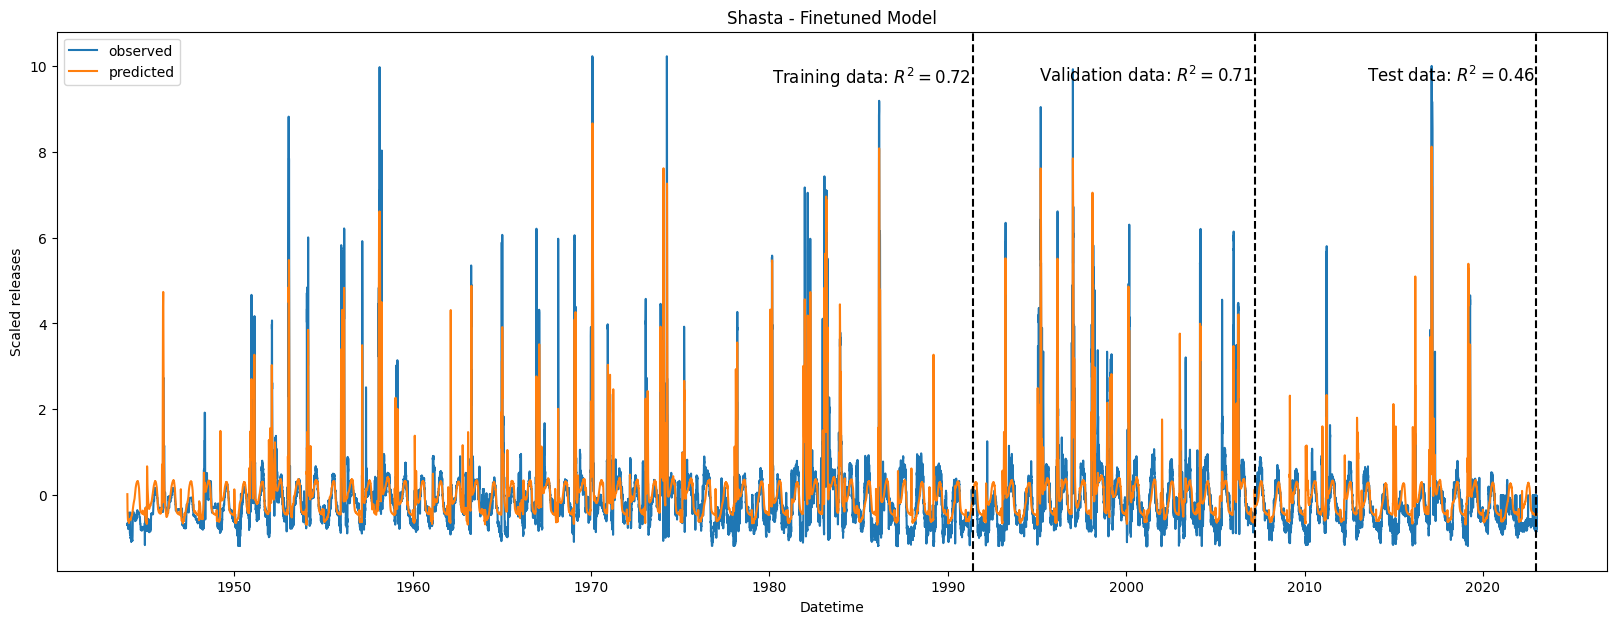

In [42]:
fig, ax = plt.subplots(figsize=(20, 7))
plot_and_eval(shasta_finetune_model, X_train=X_train_shasta, X_val=X_val_shasta, X_test=X_test_shasta,
              y_train=y_train_shasta, y_val=y_val_shasta, y_test=y_test_shasta,
              datetime_index=pd.date_range(start='1944-01-01', end='2022-12-31', freq='D'),
              ax=ax, text_ypos=10)
ax.set_title('Shasta - Finetuned Model')
plt.show()

The finetuned model performs essentially the same (slightly better) as Model 1a (trained only with Shasta)

### Try for New Melones

In [43]:
# Create PyTorch Dataset and Dataloader from training and validation
dataset_train_melones, dataset_val_melones = (TensorDataset(X_train_melones, y_train_melones), TensorDataset(X_val_melones, y_val_melones))
dataloader_train_melones, dataloader_val_melones = (DataLoader(dataset_train_melones, batch_size=1, shuffle=False), 
                                    DataLoader(dataset_val_melones, batch_size=1, shuffle=False))

In [44]:
# Instantiate New Melones finetuning model
torch.manual_seed(0)
melones_finetune_model = LSTMModel1_finetune(simul_model=model)
criterion = nn.MSELoss()
optimizer = optim.Adam(melones_finetune_model.parameters(), lr=0.001)

In [45]:
# Run training loop (finetune model to New Melones)
train_losses_melones, val_losses_melones = training_loop(model=melones_finetune_model, criterion=criterion, optimizer=optimizer, 
                                        patience=10, dataloader_train=dataloader_train_melones, 
                                        dataloader_val=dataloader_val_melones, epochs=1000)

Training epochs:   2%|▏         | 16/1000 [00:02<02:30,  6.55it/s]


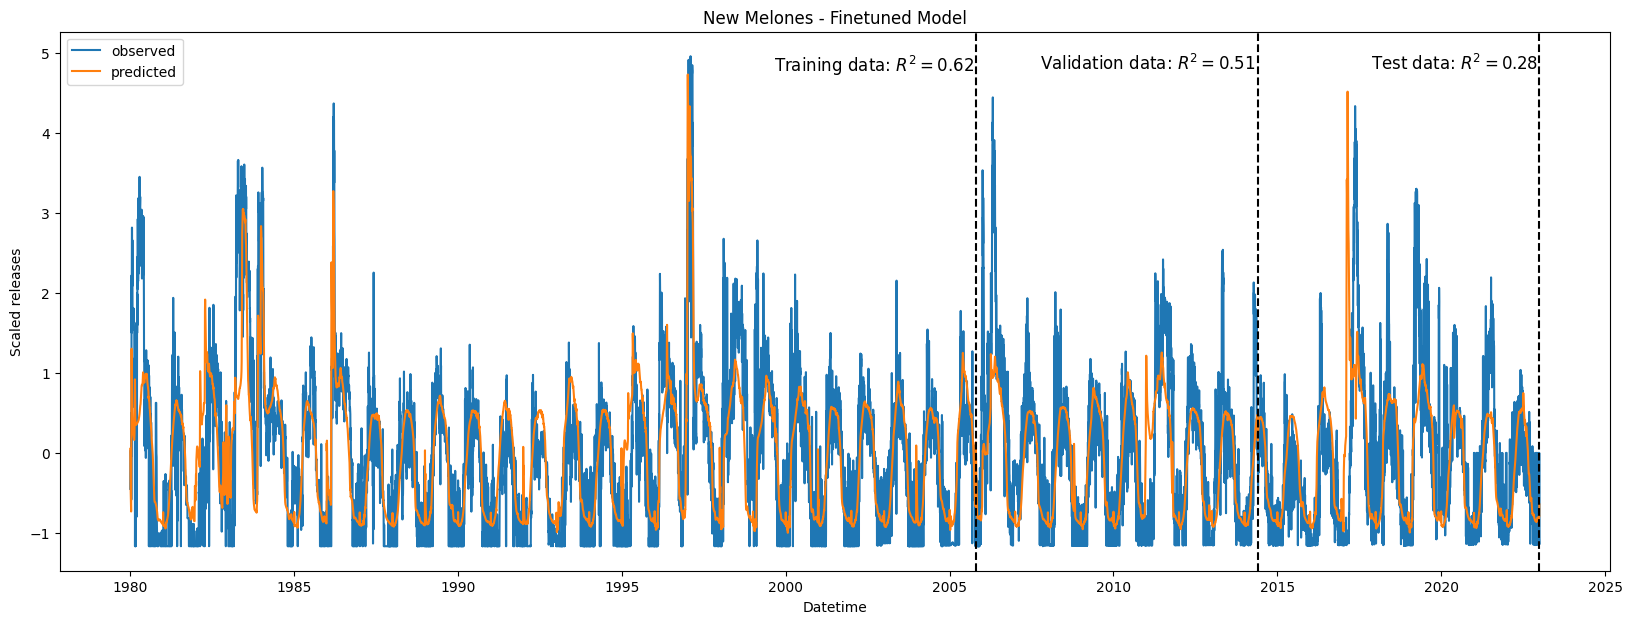

In [47]:
fig, ax = plt.subplots(figsize=(20, 7))
plot_and_eval(melones_finetune_model, X_train=X_train_melones, X_val=X_val_melones, X_test=X_test_melones,
              y_train=y_train_melones, y_val=y_val_melones, y_test=y_test_melones,
              datetime_index=pd.date_range(start='1980-01-01', end='2022-12-31', freq='D'),
              ax=ax, text_ypos=5)
ax.set_title('New Melones - Finetuned Model')
plt.show()